In [1]:
import os
import gc
import shutil
import joblib
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import torch 
import lightgbm as lgb
import optuna

# korean font error
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


# this code is essential for applying progress_apply() in pandas series object
tqdm.pandas()

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

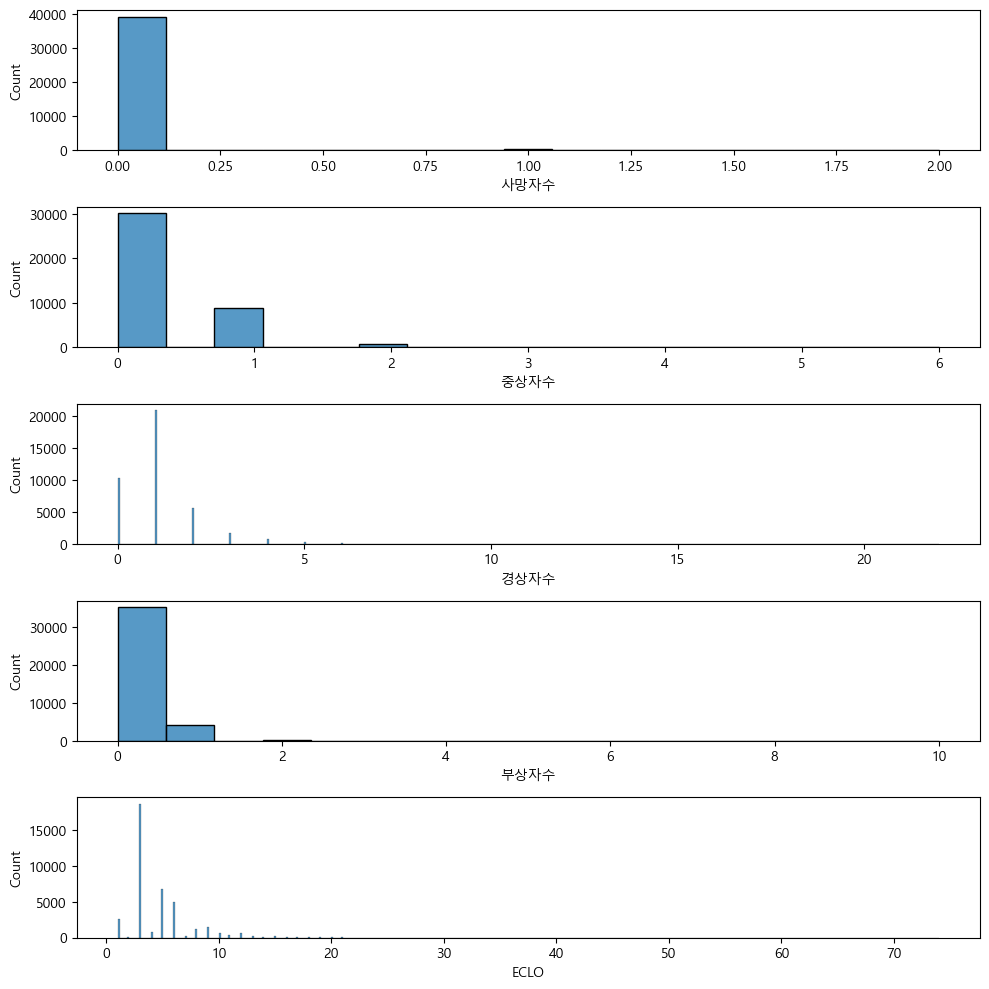

In [4]:
target=['사망자수','중상자수','경상자수', '부상자수','ECLO']

fig,ax=plt.subplots(len(target),1,figsize=(10,10))
for i,t in enumerate(target):
    sns.histplot(x=train[t], ax=ax[i])

plt.tight_layout()
plt.show()

In [5]:
train['경상자수'].unique()

array([ 0,  1,  2,  6,  3,  4,  5,  9,  8,  7, 14, 11, 10, 15, 12, 18, 13,
       22], dtype=int64)

In [6]:
train['ECLO'].unique()

array([ 5,  3,  6, 18,  9,  8, 15,  2,  1,  7,  4, 12, 13, 10, 11, 16, 40,
       22, 21, 17, 25, 14, 20, 27, 19, 24, 26, 23, 28, 31, 30, 47, 36, 33,
       34, 35, 37, 65, 56, 32, 57, 45, 52, 74, 39, 66], dtype=int64)

In [7]:
train['중상자수'].unique()

array([1, 0, 3, 2, 4, 5, 6], dtype=int64)

In [8]:
train['사망자수'].unique()

array([0, 1, 2], dtype=int64)

In [9]:
test.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [11]:
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


EDA
==============

c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


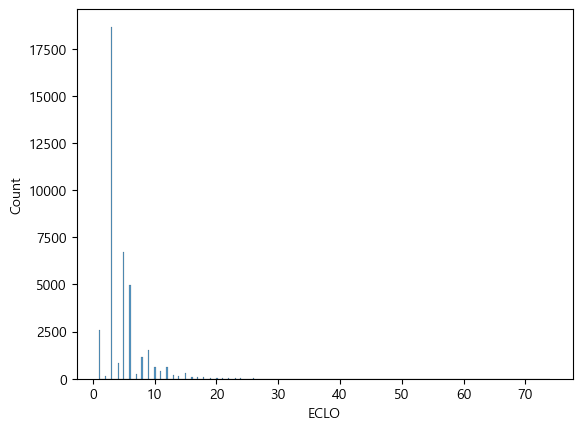

Counter({3: 18675, 5: 6743, 6: 4967, 1: 2578, 9: 1528, 8: 1152, 4: 818, 12: 611, 10: 611, 11: 394, 15: 283, 7: 263, 13: 194, 2: 150, 14: 145, 16: 101, 18: 89, 17: 78, 20: 39, 19: 36, 21: 33, 24: 18, 22: 17, 23: 17, 26: 12, 27: 11, 25: 7, 28: 6, 30: 5, 31: 4, 34: 3, 37: 3, 32: 3, 33: 2, 35: 2, 40: 1, 47: 1, 36: 1, 65: 1, 56: 1, 57: 1, 45: 1, 52: 1, 74: 1, 39: 1, 66: 1})
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 45, 47, 52, 56, 57, 65, 66, 74]


In [12]:
# distribution of target

sns.histplot(train['ECLO'])
plt.show()

from collections import Counter

count_ECLO=Counter(train['ECLO'])
print(count_ECLO)
print(sorted(count_ECLO.keys()))


c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

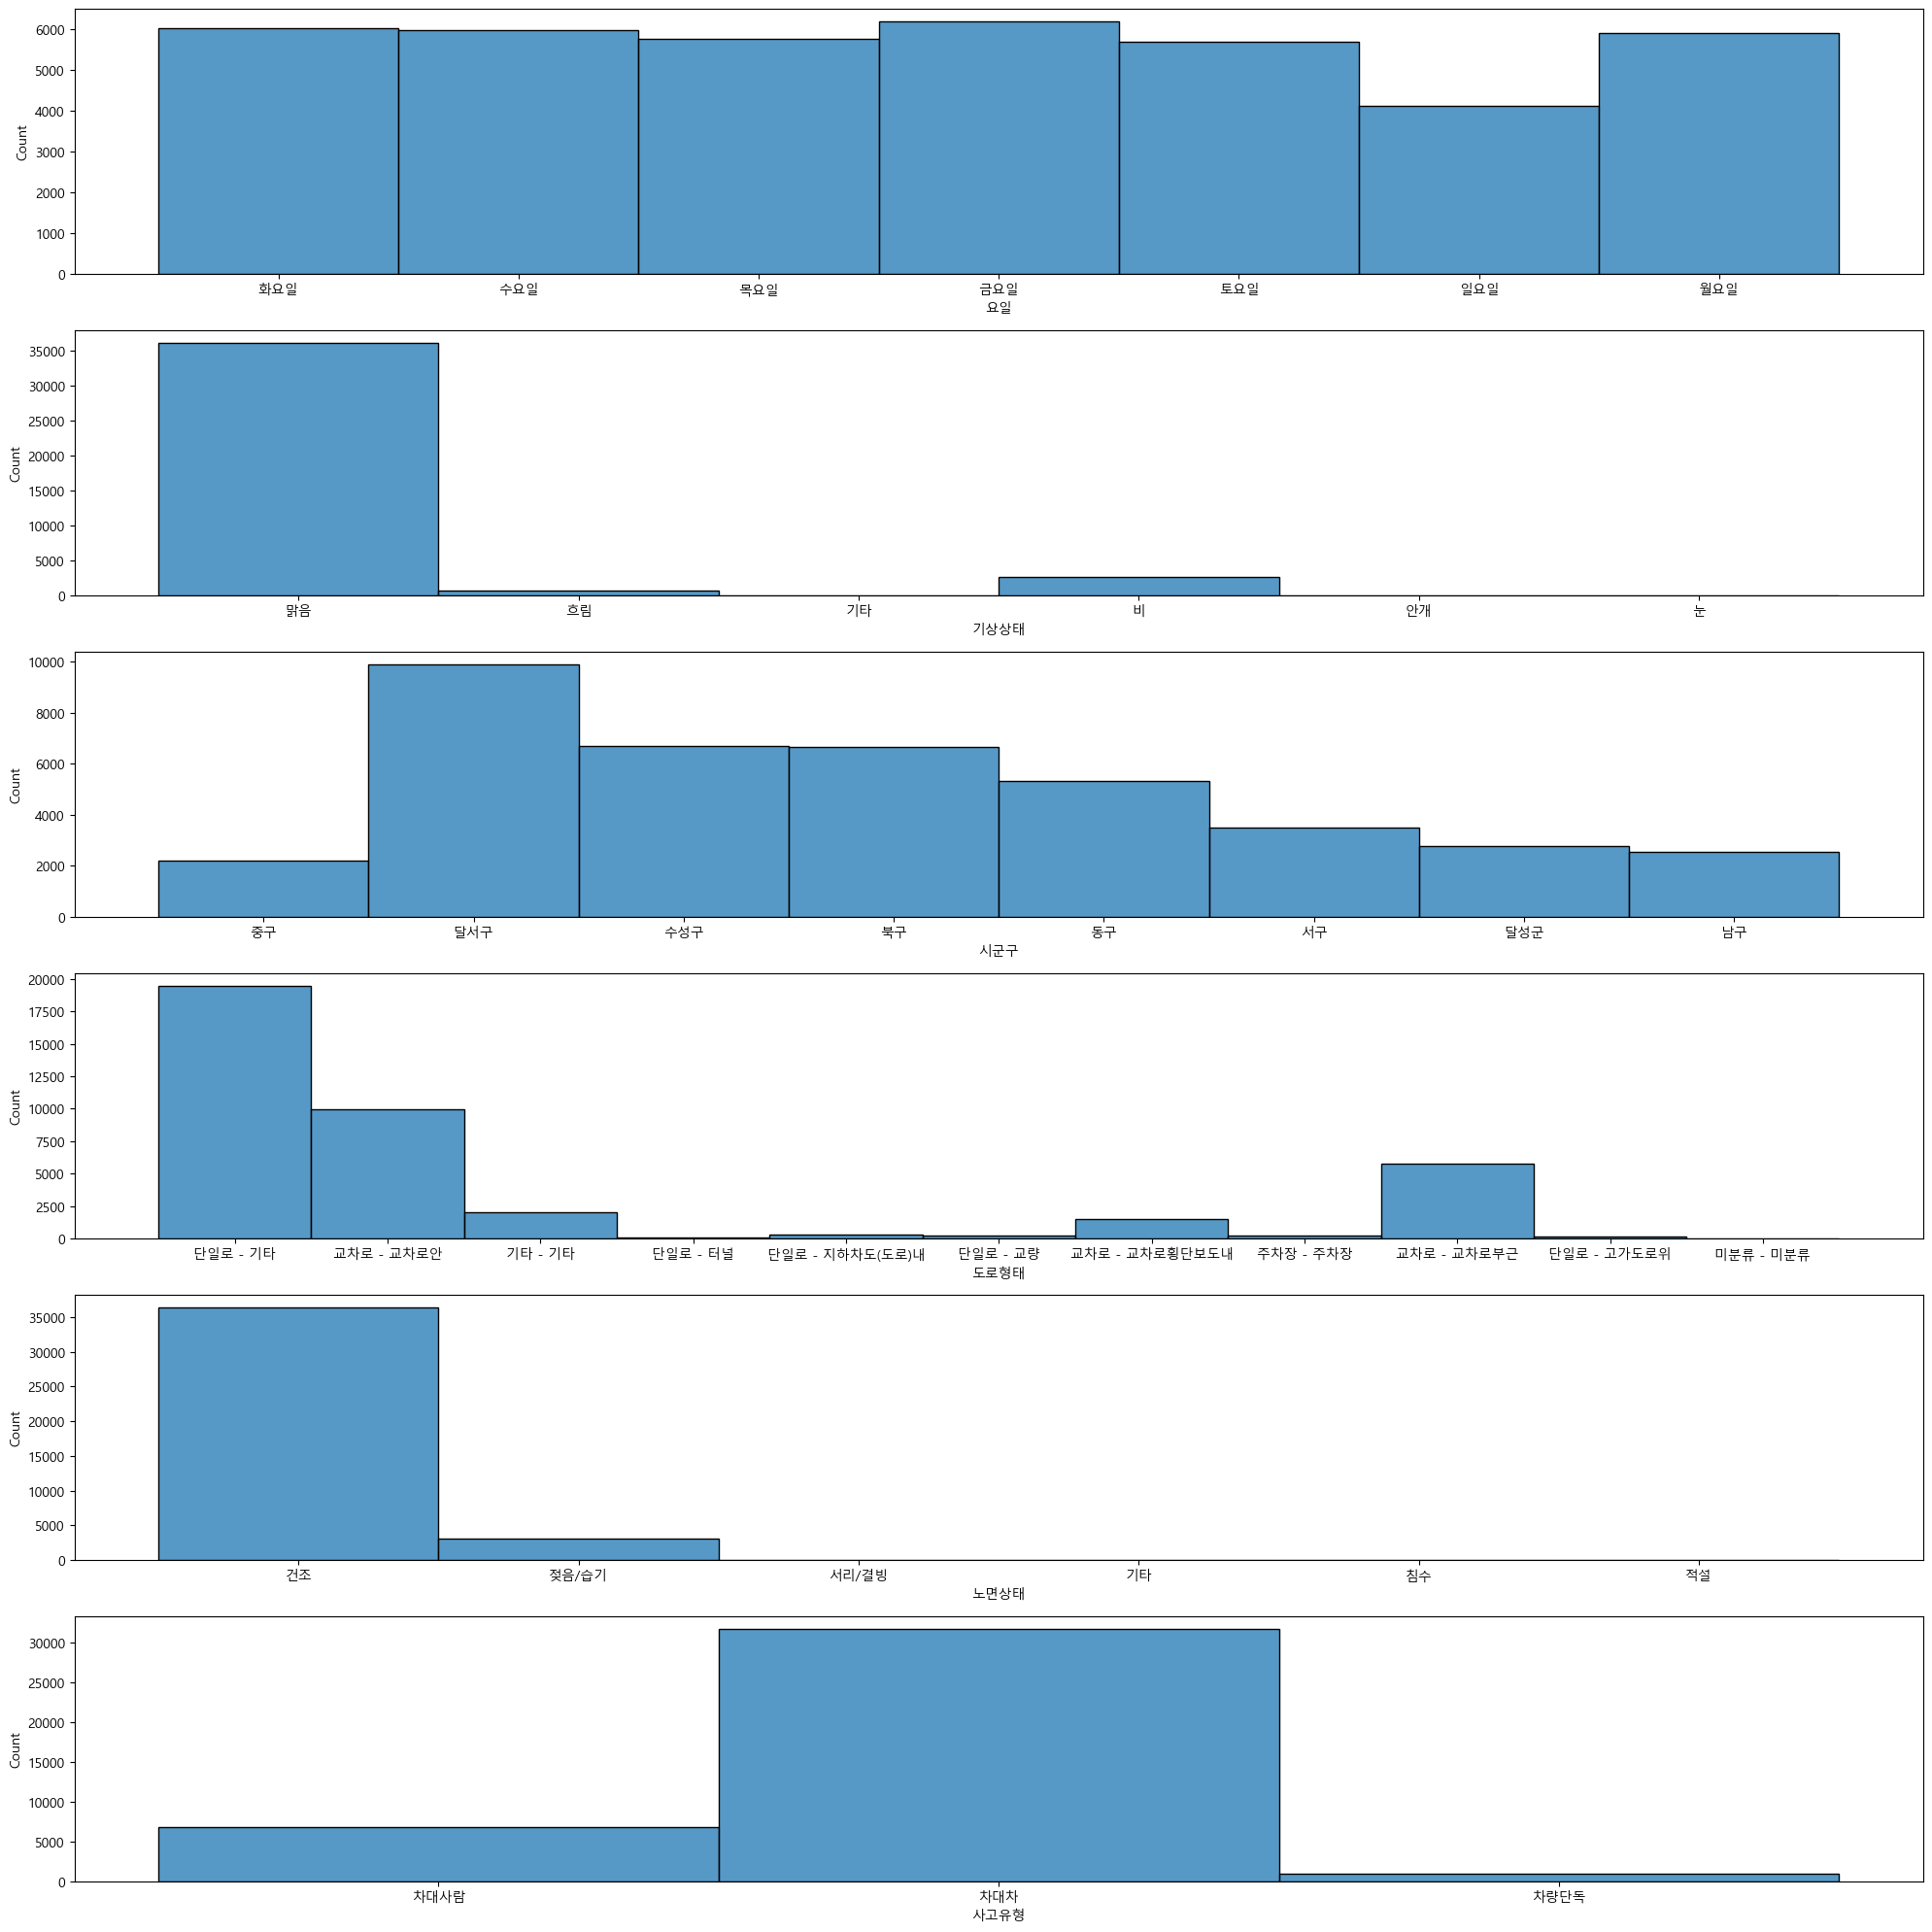

In [13]:
train_test_features=['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형']
train_only_features=['사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수']

fig,ax=plt.subplots(len(train_test_features),1,figsize=(20,20))

for i,feature in enumerate(train_test_features):
    if feature=='시군구':
        train_feature=train[feature].apply(lambda x: x.split(" ")[1])
    else:
        train_feature=train[feature]
    sns.histplot(train_feature,ax=ax[i])
    
plt.tight_layout()
plt.show()

c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

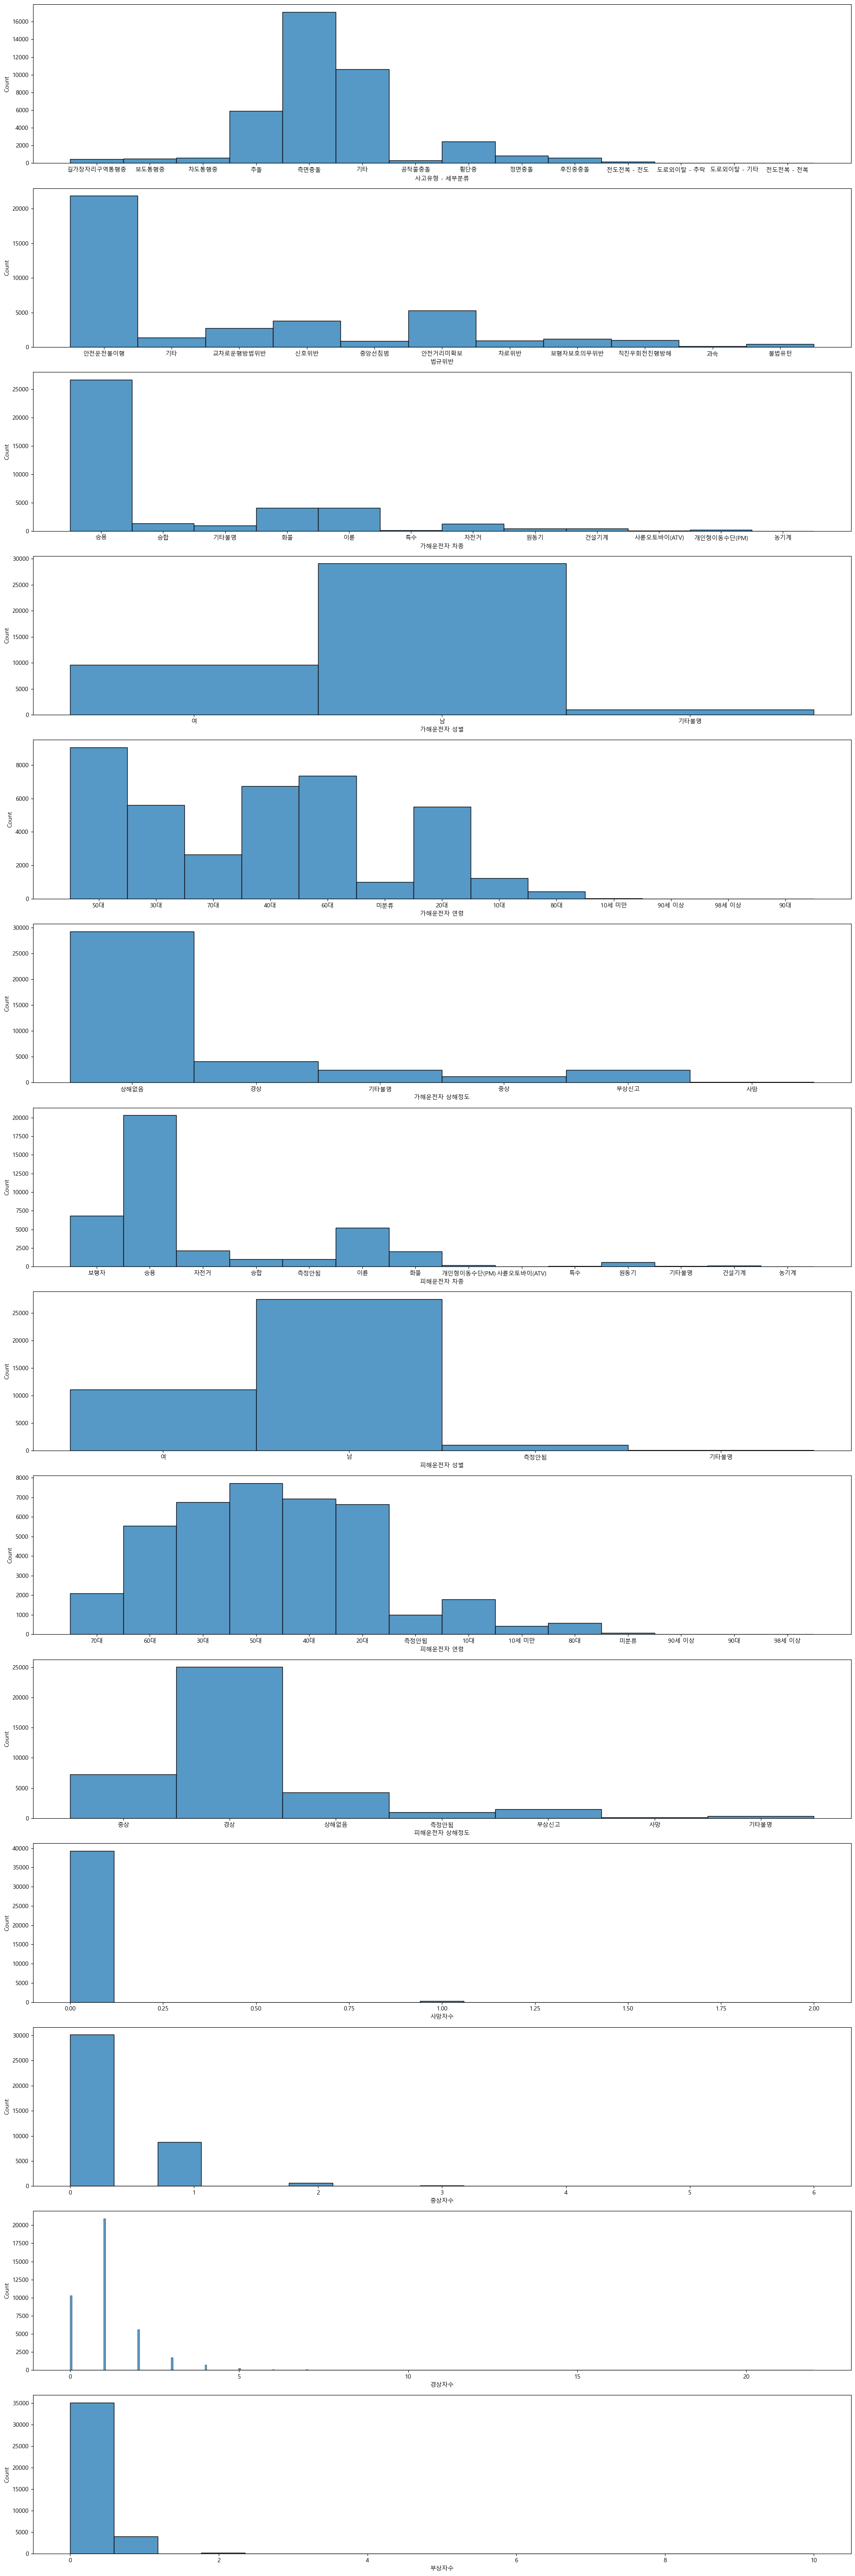

In [14]:
fig,ax=plt.subplots(len(train_only_features),1,figsize=(20,60))

train_=train.copy()
train_.fillna("측정안됨", inplace=True)

def age_clf(x):
    try:
        int(x[:-1])
        if int(x[:-1])>=10:
            return x[:1]+"0대"
        else:
            return "10세 미만"
    except:
        return x
         

for i,feature in enumerate(train_only_features):
    if feature[-2:]=="연령":
        sns.histplot(train_[feature].apply(age_clf), ax=ax[i])
    else:
        sns.histplot(train_[feature],ax=ax[i])

plt.tight_layout()
plt.show()

c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\MINSEOK\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

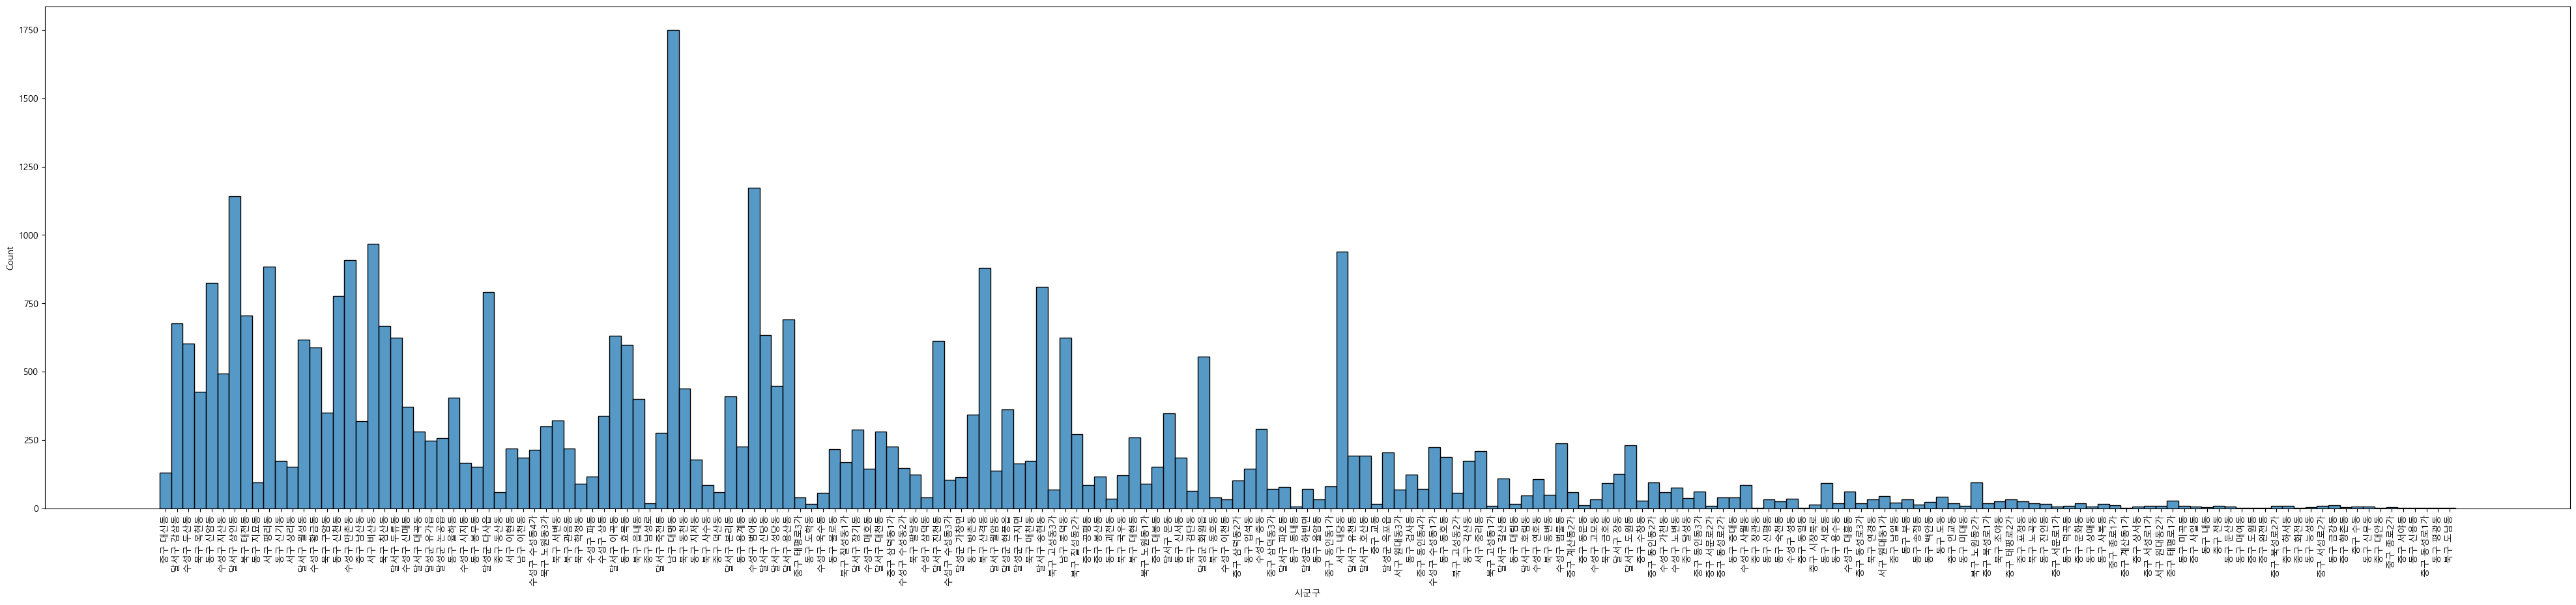

In [15]:
plt.figure(figsize=(50,10))
sns.histplot(train['시군구'].apply(lambda x: x[6:]))
plt.xticks(rotation=90)

In [16]:
daegu_security_light=pd.read_csv('./external_open/대구 보안등 정보.csv', encoding='cp949')
daegu_security_child=pd.read_csv('./external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949')
daegu_parking_lot=pd.read_csv('./external_open/대구 주차장 정보.csv', encoding='cp949')
daegu_cctv=pd.read_csv('./external_open/대구 CCTV 정보.csv', encoding='cp949')
countrywide_accident=pd.read_csv('./external_open/countrywide_accident.csv', encoding='UTF8')

C:\Users\MINSEOK\AppData\Local\Temp\ipykernel_24300\1220747278.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  daegu_security_light=pd.read_csv('./external_open/대구 보안등 정보.csv', encoding='cp949')


In [17]:
daegu_security_light.head()

,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주


In [18]:
daegu_security_light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   보안등위치명    71913 non-null  object 
 1   설치개수      71913 non-null  int64  
 2   소재지도로명주소  34646 non-null  object 
 3   소재지지번주소   71913 non-null  object 
 4   위도        43602 non-null  float64
 5   경도        43602 non-null  float64
 6   설치연도      29397 non-null  float64
 7   설치형태      35373 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.4+ MB


In [19]:
daegu_security_child.head()

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),대구광역시 남구 대명동 1709,35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),대구광역시 남구 이천동 477,35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),대구광역시 남구 대명동 3050,35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,대구광역시 남구 대명동 531-1,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,대구광역시 남구 대명동 960,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23


In [20]:
daegu_security_child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   대상시설명     640 non-null    object 
 2   소재지도로명주소  640 non-null    object 
 3   소재지지번주소   555 non-null    object 
 4   위도        640 non-null    float64
 5   경도        640 non-null    float64
 6   관리기관명     640 non-null    object 
 7   관할경찰서명    640 non-null    object 
 8   CCTV설치여부  640 non-null    object 
 9   CCTV설치대수  465 non-null    float64
 10  보호구역도로폭   320 non-null    object 
 11  데이터기준일자   640 non-null    object 
dtypes: float64(3), object(9)
memory usage: 60.1+ KB


In [21]:
daegu_parking_lot.head()

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01
2,153-2-000003,대명2동공영주차장,공영,노외,대구광역시 남구 중앙대로45길 57,대구광역시 남구 대명동 1803-10,31,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,40000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.855011,128.589359,2020-01-01
3,153-2-000004,고산골공영주차장,공영,노외,대구광역시 남구 용두2길 43,대구광역시 남구 봉덕동 1256,88,2,미시행,평일+토요일+공휴일,...,10.0,100.0,210.0,2000.0,20000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.830066,128.603443,2020-01-01
4,153-2-000005,봉덕시장공영주차장,공영,노외,대구광역시 남구 봉덕로25길 6,대구광역시 남구 봉덕동 976-5,32,1,미시행,평일+토요일+공휴일,...,10.0,200.0,160.0,3000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.844925,128.602667,2020-01-01


In [22]:
daegu_parking_lot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주차장관리번호      871 non-null    object 
 1   주차장명         871 non-null    object 
 2   주차장구분        871 non-null    object 
 3   주차장유형        871 non-null    object 
 4   소재지도로명주소     674 non-null    object 
 5   소재지지번주소      775 non-null    object 
 6   주차구획수        871 non-null    int64  
 7   급지구분         871 non-null    int64  
 8   부제시행구분       871 non-null    object 
 9   운영요일         871 non-null    object 
 10  평일운영시작시각     871 non-null    object 
 11  평일운영종료시각     871 non-null    object 
 12  토요일운영시작시각    871 non-null    object 
 13  토요일운영종료시각    871 non-null    object 
 14  공휴일운영시작시각    871 non-null    object 
 15  공휴일운영종료시각    871 non-null    object 
 16  요금정보         871 non-null    object 
 17  주차기본시간       871 non-null    int64  
 18  주차기본요금       871 non-null    int64  
 19  추가단위시간  

In [23]:
daegu_cctv.head()

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0


In [24]:
daegu_cctv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1063 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-null   float64
dtypes: float

In [25]:
countrywide_accident.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,2019-01-01 00,화요일,맑음,서울특별시 강서구 방화동,교차로 - 교차로횡단보도내,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,40세,경상,0,0,1,0,3
1,COUNTRYWIDE_ACCIDENT_000001,2019-01-01 00,화요일,맑음,경기도 포천시 소흘읍,교차로 - 교차로안,건조,차대차,기타,직진우회전진행방해,...,상해없음,이륜,남,20세,경상,0,0,1,0,3
2,COUNTRYWIDE_ACCIDENT_000002,2019-01-01 00,화요일,맑음,경기도 양주시 고암동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,17세,중상,0,1,0,0,5
3,COUNTRYWIDE_ACCIDENT_000003,2019-01-01 00,화요일,맑음,경기도 남양주시 다산동,기타 - 기타,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,10세,중상,0,2,0,0,10
4,COUNTRYWIDE_ACCIDENT_000004,2019-01-01 00,화요일,맑음,인천광역시 부평구 부평동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,승용,남,56세,경상,0,0,2,1,7


In [26]:
countrywide_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602775 entries, 0 to 602774
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           602775 non-null  object
 1   사고일시         602775 non-null  object
 2   요일           602775 non-null  object
 3   기상상태         602775 non-null  object
 4   시군구          602775 non-null  object
 5   도로형태         602775 non-null  object
 6   노면상태         602774 non-null  object
 7   사고유형         602775 non-null  object
 8   사고유형 - 세부분류  602775 non-null  object
 9   법규위반         602775 non-null  object
 10  가해운전자 차종     602775 non-null  object
 11  가해운전자 성별     602775 non-null  object
 12  가해운전자 연령     602775 non-null  object
 13  가해운전자 상해정도   602775 non-null  object
 14  피해운전자 차종     576948 non-null  object
 15  피해운전자 성별     576946 non-null  object
 16  피해운전자 연령     576949 non-null  object
 17  피해운전자 상해정도   576946 non-null  object
 18  사망자수         602775 non-null  int64 
 19  중상

Strategy
===========


- ECLO 그냥 예측
- 사망자(범주형), 중상자수(범주형), 경상자수(연속형), 부상자수(연속형) 예측 후 수식대로 직접 계산


model
--------

1. keras or torch sequential model
2. random forest, xgboost, naive bayes /adaboost svm / k-means

features
-----------

1. base('요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형')
2. cctv 개수, 제한속도+단속구분
3. 주차장 개수, 영업시간
4. 어린이보호구역 개수, cctv 개수/여부, 도로폭
5. 보안등 개수 

**중요 : 2022년 후에도 일정할 것으로 예상될 데이터만 외부 데이터 사용, 아니면 의미없음**

outliers
------------

?

missing values
------------

위의 feature 들은 결측치 없음

Preprocessing
==============

In [ ]:
from sklearn.preprocessing import OneHotEncoder

class Preprocessing:
    
    def __init__(self, 
                cat_columns: list(str),
                cctv_col: list(str),
                parking_lot_col: list(str),
                security_child_col: list(str),
                security_light_col: list(str),
                external_data_list: list(pd.DataFrame),
                merge_std_col: list(str)):
        
        self.cat_columns=cat_columns
        self.cctv_col=cctv_col
        self.parking_lot_col=parking_lot_col
        self.security_child_col=security_child_col
        self.security_light_col=security_light_col
        self.external_data_list=external_data_list
        self.merge_std_col=merge_std_col
    
    def one_hot_encoding(self, train_df, test_df, cat_columns: list(str)):
    
        for i, col in enumerate(cat_columns):
           ohe=OneHotEncoder(sparse_output=False)
           train_ohe=train_df[col].values.reshape(-1,1)
           test_ohe=test_df[col].values.reshape(-1,1)
           
           ohe.fit(train_ohe)
           print(f'cat for {col}:', ohe.categories_)
           ohe_features_names=ohe.get_feature_names_out
           
           train_ohe=ohe.transform(train_ohe)
           ohe_train_df=pd.DataFrame(train_ohe, columns=ohe_features_names)
           train_df=pd.concat([train_df, ohe_train_df], axis=1).drop(col, axis=1)
           
           test_ohe=ohe.transform(test_ohe)
           ohe_test_df=pd.DataFrame(test_ohe, columns=ohe_features_names)
           test_df=pd.concat([test_df, ohe_test_df], axis=1).drop(col, axis=1)
           
    def cctv_num(self, cctv_df: pd.DataFrame, cctv_col:list(str)):
        cctv_df["구동"]=cctv_df['소재지지번주소'].apply(lambda x: " ".join(x.split(" ")[1,2]))
        cctv_df=cctv_df.groupby("구동").sum().reset_index().loc[:,cctv_col]
        
    def parking_lot_num(self, parking_lot_df: pd.DataFrame, parking_lot_col:list(str)):
        parking_lot_df["구동"]=parking_lot_df['소재지지번주소'].apply(lambda x: " ".join(x.split(" ")[1,2]))
        parking_lot_df=parking_lot_df.groupby("구동").sum().reset_index().loc[:,parking_lot_col]
        
    def security_child_num(self, security_child_df: pd.DataFrame, security_child_col:list(str)):
        security_child_df["구동"]=security_child_df['소재지지번주소'].apply(lambda x: " ".join(x.split(" ")[1,2]))
        security_child_df=security_child_df.groupby("구동").sum().reset_index().loc[:,security_child_col]
        
    def security_light_num(self, security_light_df: pd.DataFrame, security_light_col:list(str)):
        security_light_df["구동"]=security_light_df['소재지지번주소'].apply(lambda x: " ".join(x.split(" ")[1,2]))
        security_light_df=security_light_df.groupby("구동").sum().reset_index().loc[:,security_light_col]
        
    def external_data_merge(self,external_data_list: list(pd.DataFrame), merge_std_col: list(str)):
        external_data_merged=external_data_list[0]
        
        for df in external_data_list[1:]:
            external_data_merged=pd.merge(external_data_merged, df, on=merge_std_col)
            
        return external_data_merged
    
    def sigungu_to_gudong(self, data):
        data['구동']=data['시군구'].apply(lambda x: x[6:])
            
            
    def run(self, train_df, test_df):
        # 설계 미스로 external_data_list 리스트에 외부 데이터 데이터프레임을 순서에 맞게 넣어야 함. cctv-주차장-어린이보호-보안등 순서
        # 수정 필요
        self.one_hot_encoding(train_df, test_df, self.cat_columns)
        print("-----one hot encoding finished!-----")
        
        self.cctv_num(self.external_data_list[0], self.cctv_col)
        print("-----cctv_num df finished!-----")
        self.parking_lot_num(self.external_data_list[1], self.parking_lot_col)
        print("-----parking_lot_num df finished!-----")
        self.security_child_num(self.external_data_list[2], self.security_child_col)
        print("-----security_child_num df finished!-----")
        self.security_light_num(self.external_data_list[3], self.security_light_col)
        print("-----security_light_num df finished!-----")
        
        # 이후 '구동'이 아니라 다른 열을 기준으로 합쳐야 할 수도 있음
        # 유연하게 수정이 필요함
        external_data_merged=self.external_data_merge(self.external_data_list, self.merge_std_col)
        print("-----external data merge finished!-----")
        
        self.sigungu_to_gudong(train_df)
        self.sigungu_to_gudong(test_df)
        
        train_df_p=pd.merge(train_df, external_data_merged, left_on="구동", right_on=self.merge_std_col)
        test_df_p=pd.merge(test_df, external_data_merged, left_on="구동", right_on=self.merge_std_col)
        
        return train_df_p, test_df_p

Model training & Validation
===========================

Prediction
===========

Submission
==================